## Prova di Classificazione email

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


,email,label
0,Subject: re : vacation\n vincent :\n congratul...,ham
1,"Subject: re : industrials\n robert ,\n i never...",ham
2,Subject: midtex\n after comparing hpl ' s numb...,ham
3,Subject: = ? ansi _ x 3 . 4 - 1968 ? q ? use _...,ham
4,Subject: schedule crawler : hourahead failure\...,ham
5,"Subject: hpl nom for december 22 , 2000\n ( se...",ham
6,Subject: re : gtc change for removal of hpl la...,ham
7,Subject: hpl staffing\n attached is the reques...,ham
8,Subject: netco required contracts\n counterpar...,ham
9,Subject: longview dash request\n louise :\n a ...,ham


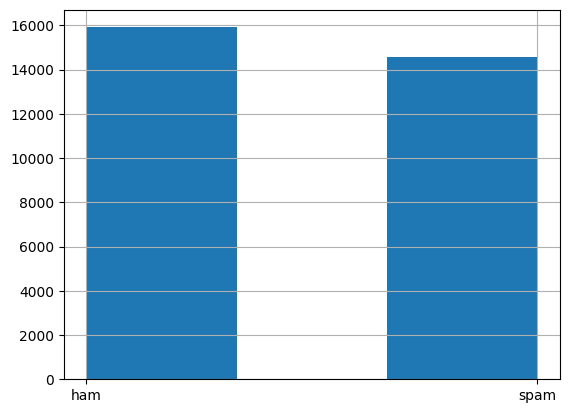

In [15]:
from os import walk
from string import punctuation
from random import shuffle
from collections import Counter

# Importing additional libraries

import pandas as pd
import sklearn as sk
import nltk

from pandarallel import pandarallel

# Initialization
pandarallel.initialize(progress_bar=True)

# Read the whole data from the Enron Dataset into a variable allData.

pathwalk = walk(r"enron-spam/")

allHamData, allSpamData = [], []
for root, dr, file in pathwalk:
    if 'ham' in str(file):
        for obj in file:
            with open(root + '/' + obj, encoding='latin1') as ip:
                allHamData.append(" ".join(ip.readlines()))

    elif 'spam' in str(file):
        for obj in file:
            with open(root + '/' + obj, encoding='latin1') as ip:
                allSpamData.append(" ".join(ip.readlines()))
                # remove all redundant data

allHamData = list(set(allHamData))
allSpamData = list(set(allSpamData))
# storing it in a dataframe

hamPlusSpamData = allHamData + allSpamData
labels = ["ham"]*len(allHamData) + ["spam"]*len(allSpamData)

raw_df = pd.DataFrame({"email": hamPlusSpamData,
                       "label": labels})

# get an overview of the data

raw_df.label.hist(bins=3)
raw_df.head(10)

In [16]:
from nltk.tokenize import RegexpTokenizer
# check for null value
raw_df.isnull().sum()
#Pre-processing
tokenizer = RegexpTokenizer("[A-Za-z]+")
raw_df.email[0]
tokenizer.tokenize(raw_df.email[0])

['Subject',
 're',
 'vacation',
 'vincent',
 'congratulations',
 'please',
 'take',
 'whatever',
 'time',
 'is',
 'necessary',
 'i',
 'hope',
 'the',
 'complications',
 'are',
 'only',
 'with',
 'the',
 'in',
 'laws',
 'and',
 'not',
 'the',
 'police',
 'u',
 's',
 'immigration',
 'etc',
 'let',
 'me',
 'know',
 'if',
 'there',
 'is',
 'anything',
 'we',
 'can',
 'do',
 'for',
 'you',
 'regards',
 'grant',
 'vincent',
 'tang',
 'on',
 'pm',
 'to',
 'grant',
 'masson',
 'enron',
 'com',
 'cc',
 'subject',
 'hi',
 'grant',
 'how',
 'are',
 'you',
 'hope',
 'everything',
 'is',
 'going',
 'well',
 'my',
 'wedding',
 'ceremony',
 'was',
 'very',
 'good',
 'but',
 'the',
 'whole',
 'process',
 'is',
 'more',
 'complex',
 'than',
 'i',
 'expected',
 'it',
 'might',
 'take',
 'several',
 'more',
 'days',
 'so',
 'i',
 'am',
 'wondering',
 'if',
 'it',
 'is',
 'not',
 'too',
 'much',
 'a',
 'trouble',
 'for',
 'you',
 'i',
 'would',
 'like',
 'to',
 'extend',
 'my',
 'vacation',
 'several',
 '

In [17]:
from nltk.stem.snowball import SnowballStemmer
raw_df['text_tokenized'] = raw_df.email.parallel_map(lambda t: tokenizer.tokenize(str(t)))
stemmer = SnowballStemmer("english")
raw_df['text_stemmed'] = raw_df['text_tokenized'].parallel_map(lambda l: [stemmer.stem(word) for word in l])
raw_df['text_sent'] = raw_df['text_stemmed'].parallel_map(lambda l: ' '.join(l))

### Visualizzation

In [24]:
bad_emails = raw_df[raw_df.label == 'spam']
good_emails = raw_df[raw_df.label == 'ham']

raw_df.head()

,email,label,text_tokenized,text_stemmed,text_sent
0,Subject: re : vacation\n vincent :\n congratul...,ham,"[Subject, re, vacation, vincent, congratulatio...","[subject, re, vacat, vincent, congratul, pleas...",subject re vacat vincent congratul pleas take ...
1,"Subject: re : industrials\n robert ,\n i never...",ham,"[Subject, re, industrials, robert, i, never, s...","[subject, re, industri, robert, i, never, saw,...",subject re industri robert i never saw the jul...
2,Subject: midtex\n after comparing hpl ' s numb...,ham,"[Subject, midtex, after, comparing, hpl, s, nu...","[subject, midtex, after, compar, hpl, s, numbe...",subject midtex after compar hpl s number with ...
3,Subject: = ? ansi _ x 3 . 4 - 1968 ? q ? use _...,ham,"[Subject, ansi, x, q, use, of, corporate, amer...","[subject, ansi, x, q, use, of, corpor, america...",subject ansi x q use of corpor american expr i...
4,Subject: schedule crawler : hourahead failure\...,ham,"[Subject, schedule, crawler, hourahead, failur...","[subject, schedul, crawler, hourahead, failur,...",subject schedul crawler hourahead failur start...


### Creating Model

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
cv = CountVectorizer()
feature = cv.fit_transform(raw_df.text_sent)
trainX, testX, trainY, testY = train_test_split(feature, raw_df.label)

### Logistic Regression

/home/giacomo/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy : 0.9991692173152602
Testing Accuracy : 0.9870146904512067

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.98      0.99      0.99      3920
        Good       0.99      0.98      0.99      3704

    accuracy                           0.99      7624
   macro avg       0.99      0.99      0.99      7624
weighted avg       0.99      0.99      0.99      7624


CONFUSION MATRIX


<AxesSubplot: >

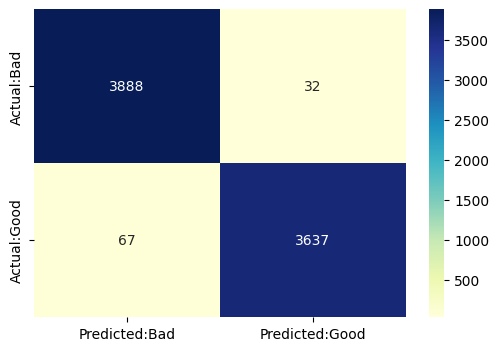

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
lr = LogisticRegression()
lr.fit(trainX,trainY)
lr.score(testX,testY)
Scores_ml = {}
Scores_ml['Logistic Regression'] = np.round(lr.score(testX,testY),2)

print('Training Accuracy :',lr.score(trainX,trainY))
print('Testing Accuracy :',lr.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(lr.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(lr.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

# Multinomial Naive Bayes

Training Accuracy : 0.9889374726716222
Testing Accuracy : 0.9862277019937041

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.99      0.99      0.99      3958
        Good       0.99      0.99      0.99      3666

    accuracy                           0.99      7624
   macro avg       0.99      0.99      0.99      7624
weighted avg       0.99      0.99      0.99      7624


CONFUSION MATRIX


<AxesSubplot: >

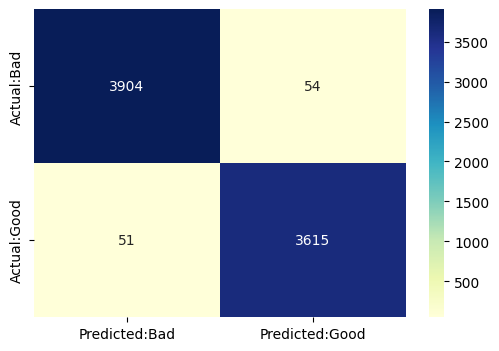

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
import pickle

mnb = MultinomialNB()
mnb.fit(trainX,trainY)
mnb.score(testX,testY)
Scores_ml['MultinomialNB'] = np.round(mnb.score(testX,testY),2)

print('Training Accuracy :',mnb.score(trainX,trainY))
print('Testing Accuracy :',mnb.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(mnb.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(mnb.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

# Support Vector Machine

Training Accuracy : 0.99995627459554
Testing Accuracy : 0.9804564533053515

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.98      0.98      0.98      3954
        Good       0.98      0.98      0.98      3670

    accuracy                           0.98      7624
   macro avg       0.98      0.98      0.98      7624
weighted avg       0.98      0.98      0.98      7624


CONFUSION MATRIX


<AxesSubplot: >

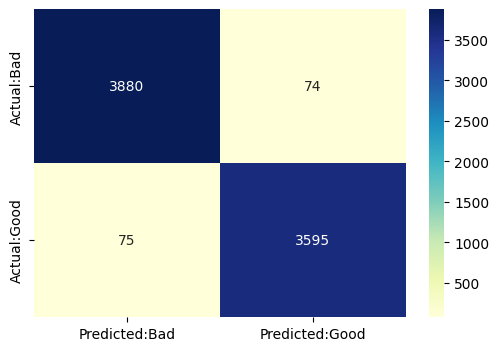

In [22]:
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
SVC_model = svm.SVC(kernel='linear')
SVC_model.fit(trainX,trainY)

print('Training Accuracy :', SVC_model.score(trainX,trainY))
print('Testing Accuracy :',SVC_model.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(SVC_model.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])

print('\nCLASSIFICATION REPORT\n')
print(classification_report(SVC_model.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")
